Hamidreza Amirzadeh

401206999

Note: This work was done under collaboration with Amirhossein Hadian

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1024

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 71060724.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(pretrained=True).children())[:-2])
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
      return self.feature_extractor(x)

    def forward(self, x):
        feature = self.get_features(x)
        return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))

In [5]:
model = Net().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 213MB/s]


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 10

In [9]:
model.train()
for epoch in range(num_epochs):
  #### To Do (4 pts) #####
  # Fine-tune model on CIFAR-10 dataset
  traininig_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    traininig_loss += loss.item()
    if i % 1000 == 1:
        print(f'epoch : {epoch + 1}, loss: {traininig_loss / 1000:.8f}')
        traininig_loss = 0.0
  ################

<ipython-input-4-5da27c78fcc5>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


epoch : 1, loss: 0.00345356
epoch : 2, loss: 0.00339504
epoch : 3, loss: 0.00335554
epoch : 4, loss: 0.00333026
epoch : 5, loss: 0.00332726
epoch : 6, loss: 0.00330525
epoch : 7, loss: 0.00334431
epoch : 8, loss: 0.00330280
epoch : 9, loss: 0.00326818
epoch : 10, loss: 0.00329681


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Standard Accuracy: {100 * correct / total} %')

<ipython-input-4-5da27c78fcc5>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


Standard Accuracy: 75.18 %


In [11]:
def poisoning_example_generation(t, b, f, lmda=0.1, max_iters=10, beta=1):
  """
  t: target instance
  b: base instance
  f: feature extractor
  lambda: learning rate
  """
  #### To Do (9 pts) #####
  # Create poisoned sample by following the algorithm you've learned in the class
  t = t.clone().detach().requires_grad_(False).to(device)
  b = b.clone().detach().requires_grad_(False).to(device)
  x = b.clone().detach().requires_grad_(True)

  def Lp(x):
      return torch.norm(f(x.unsqueeze(0)).squeeze(0) - f(t.unsqueeze(0)).squeeze(0), p=2)**2

  for _ in range(max_iters):
      loss = Lp(x)
      loss.backward()
      with torch.no_grad():
          x -= lmda * x.grad
          x = (x + lmda * beta * b) / (1 + beta * lmda)
          x.requires_grad_(True)

  sample = x
  ################

  return sample

In [21]:
def predict(input_image):
  image_array = np.array(input_image)
  image_tensor = transform(input_image).unsqueeze(0)
  output = model(image_tensor.to(device))
  _, predicted = torch.max(output.data, 1)
  plt.imshow(image_array)
  plt.title(f"Predicted class : {classes[predicted[0].item()]} / confidence : {output[0][predicted[0].item()]}")
  plt.show()

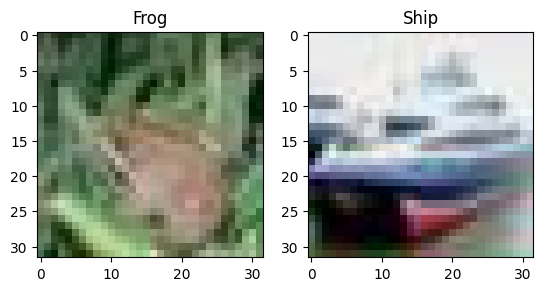

<ipython-input-4-5da27c78fcc5>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


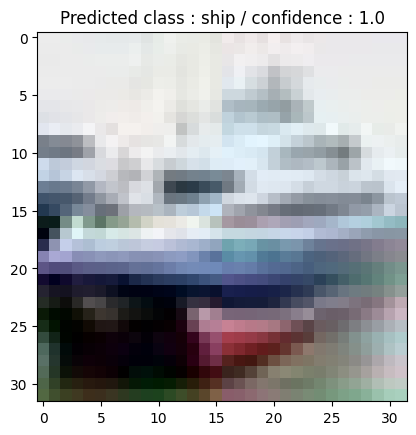

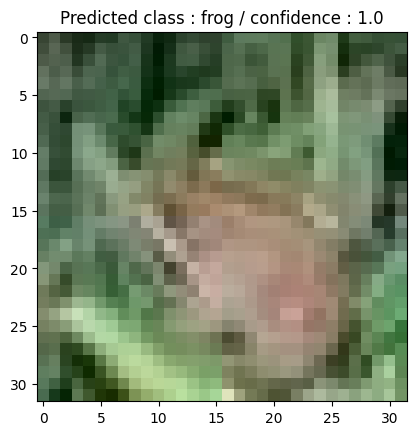

In [22]:
#### To Do (2 pts) #####
# Show the frog and ship images
# Evaluate model on them (compute predicted label)
ship = Image.open("ship.jpeg")
frog = Image.open("frog.jpeg")
frog_array = np.array(frog)
ship_array = np.array(ship)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(frog_array)
ax[0].set_title("Frog")
ax[1].imshow(ship_array)
ax[1].set_title("Ship")
plt.show()

# Evaluate
predict(ship)
predict(frog)
################

<ipython-input-4-5da27c78fcc5>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc(torch.flatten(feature, start_dim=1)))


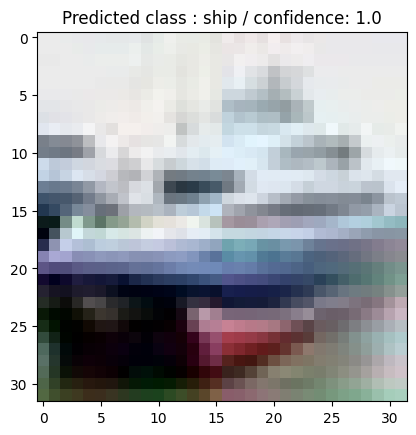

confidence of frog of base = 2.3734354461174903e-14 and of poisoned sample = 2.3734354461174903e-14


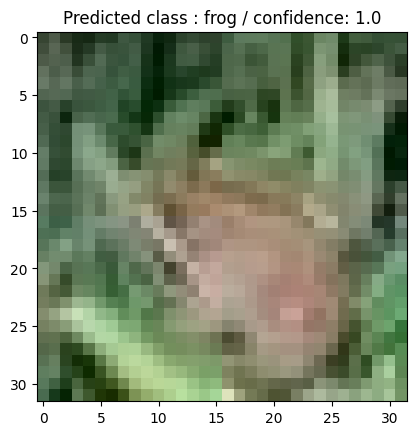

confidence of ship of base = 1.296557722296754e-10 and of poisoned sample = 1.2965602202985593e-10


In [23]:
#### To Do (2 pts) #####
# Create poisoned samples
# Evaluate model on them (compute predicted label)
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

def inference_poisoned_sample(target_image, base_image, model, target_label):
  output = model(transform(base_image).unsqueeze(0).to(device))
  confidence_target = output[0][target_label]
  poisoned_sample = poisoning_example_generation(transform(target_image), transform(base_image), model)
  image_array = inv_normalize(poisoned_sample)
  output = model(poisoned_sample.unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  predicted_label = classes[predicted[0].item()]
  confidence = output[0][predicted[0].item()]
  plt.imshow(np.transpose(image_array.detach().cpu().numpy(), (1, 2, 0)))
  plt.title(f"Predicted class : {predicted_label} / confidence: {confidence}")
  plt.show()
  print(f"confidence of {classes[target_label]} of base = {confidence_target} and of poisoned sample = {output[0][target_label]}")

inference_poisoned_sample(frog, ship, model, 6)
inference_poisoned_sample(ship, frog, model, 8)
################